In [1]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import ast
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering,OPTICS,MeanShift,MiniBatchKMeans,Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [2]:
def fill_na_with_nearest(df):
    for col in df.columns:
        # Get indices of NaNs
        nan_indices = df[df[col].isna()].index
        
        for i in nan_indices:
            # Get previous and next valid indices
            prev_idx = df[col][:i].last_valid_index()
            next_idx = df[col][i:].first_valid_index()
            
            if prev_idx is None:
                df.at[i, col] = df.at[next_idx, col]
            elif next_idx is None:
                df.at[i, col] = df.at[prev_idx, col]
            else:
                if (i - prev_idx) <= (next_idx - i):
                    df.at[i, col] = df.at[prev_idx, col]
                else:
                    df.at[i, col] = df.at[next_idx, col]
    return df

In [3]:
data = pd.read_csv('./../data/data.csv')

In [4]:
column_name = 'Nationality'

In [5]:
y=data[column_name]
x=[]

In [6]:
for index in data.index:
    real_list = ast.literal_eval(data.at[index,'error_index'])
    if data.at[index,"Gender"]=="مرد":
        real_list.extend([1])
    elif data.at[index,"Gender"]=="زن":
        real_list.extend([2])
    else:
        real_list.extend([0])
    x.append(real_list)

In [7]:
def pad_list(lst, target_length, padding_value=None):
    return lst + [padding_value] * max(0, target_length - len(lst))

In [8]:
def get_max_len(x):
    max_len=-1
    for i in x :
        if len(i)>max_len:
            max_len=len(i)
    return max_len

In [9]:
max_len=get_max_len(x)
for index in range(0,len(x)):
    x[index]=pad_list(x[index],max_len,0)

In [10]:
tsne = TSNE(n_components=2, random_state=0)
reduced_data = tsne.fit_transform(np.array(x))

C:\Users\mahboub\miniforge3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mahboub\miniforge3\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\mahboub\miniforge3\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\mahboub\miniforge3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\mahboub\miniforge3\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


In [11]:
scaler = StandardScaler()
reduced_data = scaler.fit_transform(reduced_data)

In [12]:
labels = data['Nationality']

In [13]:
reduced_df = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])
reduced_df['label'] = labels

In [14]:
reduced_df=fill_na_with_nearest(reduced_df)

In [15]:
algorithms = {
    'KMeans': KMeans(n_clusters=len(data['Nationality'].unique()), random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=len(data['Nationality'].unique())),
    'DBSCAN': DBSCAN(eps=0.05, min_samples=3),
    # 'SpectralClustering': SpectralClustering(n_clusters=len(data['Nationality'].unique()), random_state=42),      
    'Optics':OPTICS(eps=0.001, min_samples=3),
    # 'MeanShit':MeanShift(),
    'MiniBatchKmeans':MiniBatchKMeans(n_clusters=len(data['Nationality'].unique())),
    'Brich':Birch(threshold=0.01, n_clusters=len(data['Nationality'].unique())),
    "Gaussian_Mixture":GaussianMixture(n_components=len(data['Nationality'].unique()))
}

In [16]:
def evaluate_cluster_algorithm(algorithm, X,true_labels):
    labels = algorithm.fit_predict(X)

    silhouette = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    ari = adjusted_rand_score(true_labels, labels)
    nmi = normalized_mutual_info_score(true_labels, labels)
    
    return silhouette, db_index, ch_score, labels ,ari,nmi
def evaluate_cluster_algorithm_2(algorithm, X,true_labels):
    algorithm.fit(X)
    labels = algorithm.predict(X)
    
    silhouette = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    ari = adjusted_rand_score(true_labels, labels)
    nmi = normalized_mutual_info_score(true_labels, labels)
    
    return silhouette, db_index, ch_score, labels ,ari,nmi

In [17]:
results = {}
for name, algorithm in algorithms.items():
    if name in ["KMeans","Agglomerative","DBSCAN","Optics","MiniBatchKmeans"]:
        silhouette, db_index, ch_score, labels,ari,nmi = evaluate_cluster_algorithm(algorithm, reduced_data,reduced_df['label'])
    else:
        silhouette, db_index, ch_score, labels,ari,nmi = evaluate_cluster_algorithm_2(algorithm, reduced_data,reduced_df['label'])

    
    # Store results
    results[name] = {
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': db_index,
        'Calinski-Harabasz Score': ch_score,
        'Normalized Mutual Information (NMI)':nmi,
        'Adjusted Rand Index (ARI)':ari,
        'Labels': labels
    }

C:\Users\mahboub\miniforge3\lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\mahboub\miniforge3\lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


KMeans:
  Silhouette Score: 0.512
  Davies-Bouldin Index: 0.674
  Calinski-Harabasz Score: 15179.191
  Normalized Mutual Information (NMI) Score: 0.115
  Adjusted Rand Index (ARI) Score: 0.004
[ 8 19 35 ...  6 54 16]


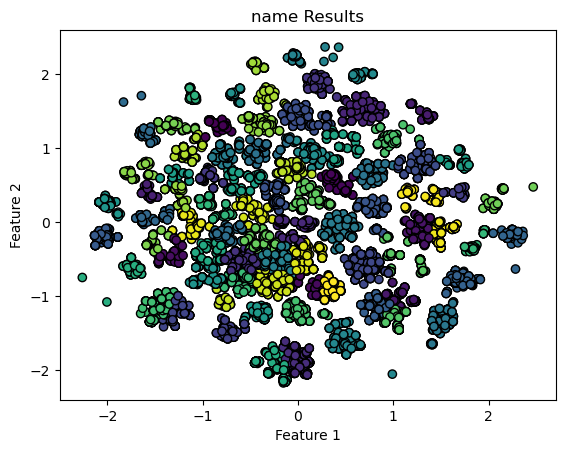


Agglomerative:
  Silhouette Score: 0.521
  Davies-Bouldin Index: 0.641
  Calinski-Harabasz Score: 15004.180
  Normalized Mutual Information (NMI) Score: 0.115
  Adjusted Rand Index (ARI) Score: 0.003
[36 61 63 ... 53  7  7]


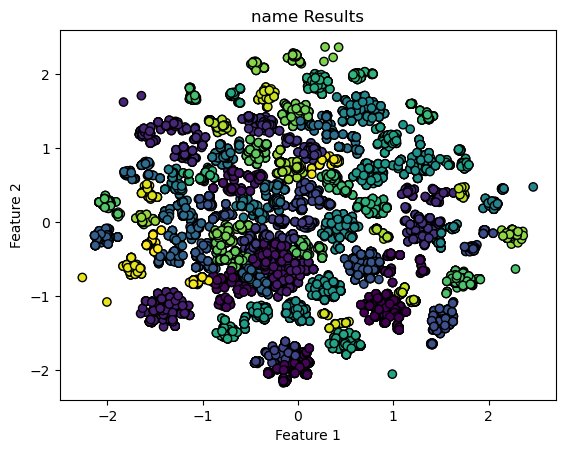


DBSCAN:
  Silhouette Score: 0.496
  Davies-Bouldin Index: 1.490
  Calinski-Harabasz Score: 1005.742
  Normalized Mutual Information (NMI) Score: 0.215
  Adjusted Rand Index (ARI) Score: 0.003
[  0   1   2 ... 217  48  71]


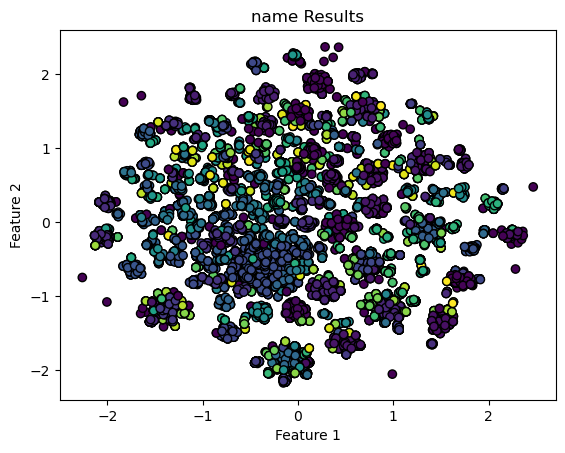


Optics:
  Silhouette Score: 0.506
  Davies-Bouldin Index: 1.399
  Calinski-Harabasz Score: 25.618
  Normalized Mutual Information (NMI) Score: 0.358
  Adjusted Rand Index (ARI) Score: -0.003
[   0   80 1468 ... 1415 1542 1535]


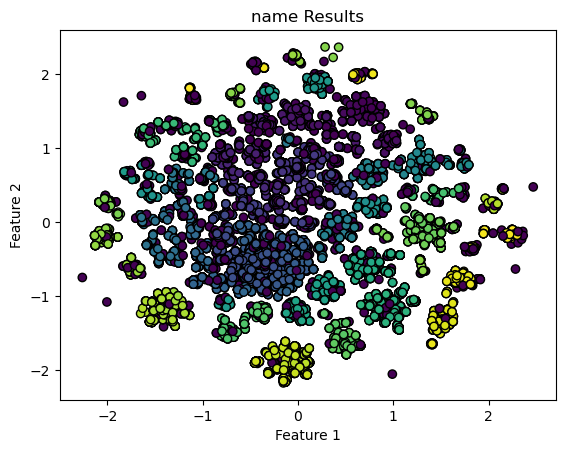


MiniBatchKmeans:
  Silhouette Score: 0.506
  Davies-Bouldin Index: 0.675
  Calinski-Harabasz Score: 14677.073
  Normalized Mutual Information (NMI) Score: 0.114
  Adjusted Rand Index (ARI) Score: 0.004
[ 2 67 45 ... 26 19 57]


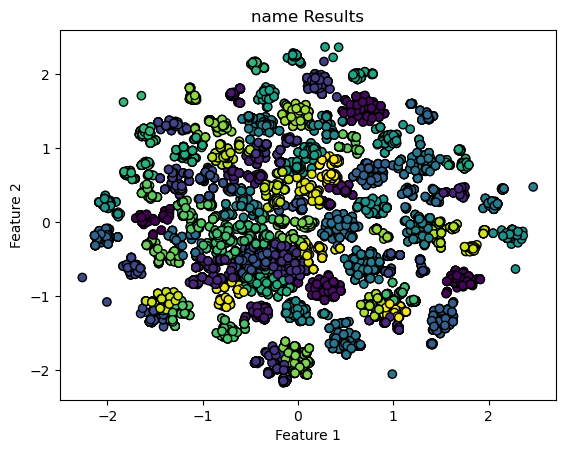


Brich:
  Silhouette Score: 0.518
  Davies-Bouldin Index: 0.647
  Calinski-Harabasz Score: 14895.262
  Normalized Mutual Information (NMI) Score: 0.116
  Adjusted Rand Index (ARI) Score: 0.003
[ 7 67 27 ... 54  1  1]


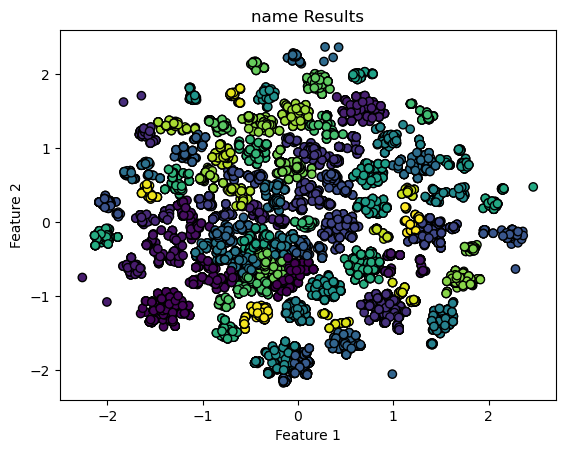


Gaussian_Mixture:
  Silhouette Score: 0.471
  Davies-Bouldin Index: 0.721
  Calinski-Harabasz Score: 11772.901
  Normalized Mutual Information (NMI) Score: 0.115
  Adjusted Rand Index (ARI) Score: 0.006
[ 9 21 52 ... 44 17 68]


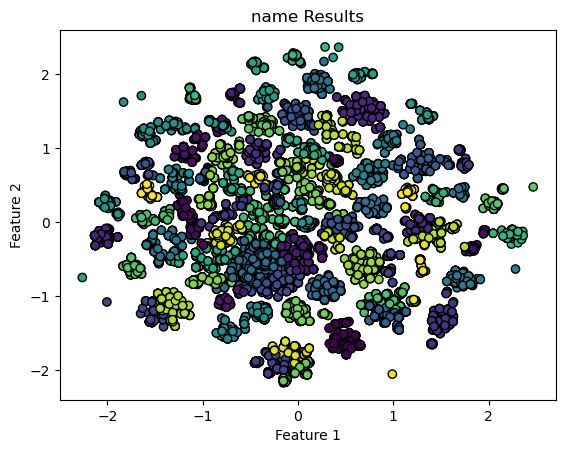

In [18]:
# Print results
for name, result in results.items():
    print(f"{name}:")
    print(f"  Silhouette Score: {result['Silhouette Score']:.3f}")
    print(f"  Davies-Bouldin Index: {result['Davies-Bouldin Index']:.3f}")
    print(f"  Calinski-Harabasz Score: {result['Calinski-Harabasz Score']:.3f}")
    print(f"  Normalized Mutual Information (NMI) Score: {result['Normalized Mutual Information (NMI)']:.3f}")
    print(f"  Adjusted Rand Index (ARI) Score: {result['Adjusted Rand Index (ARI)']:.3f}")
    print(result['Labels'])
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=result['Labels'], cmap='viridis', marker='o', edgecolor='k')
    plt.title('name Results')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    print()



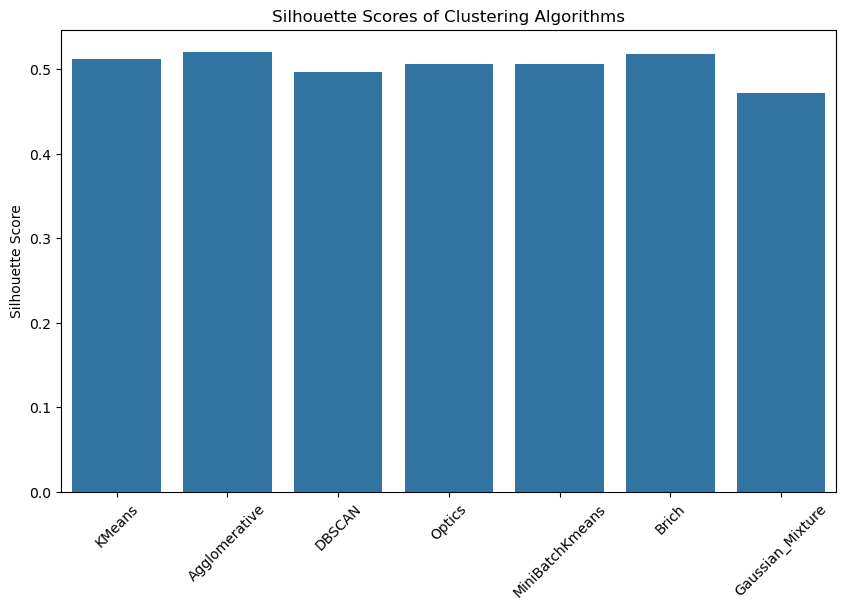

In [19]:
plt.figure(figsize=(10, 6))
scores = [results[name]['Silhouette Score'] for name in results]
sns.barplot(x=list(results.keys()),y= scores)
plt.title('Silhouette Scores of Clustering Algorithms')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45)
plt.show()

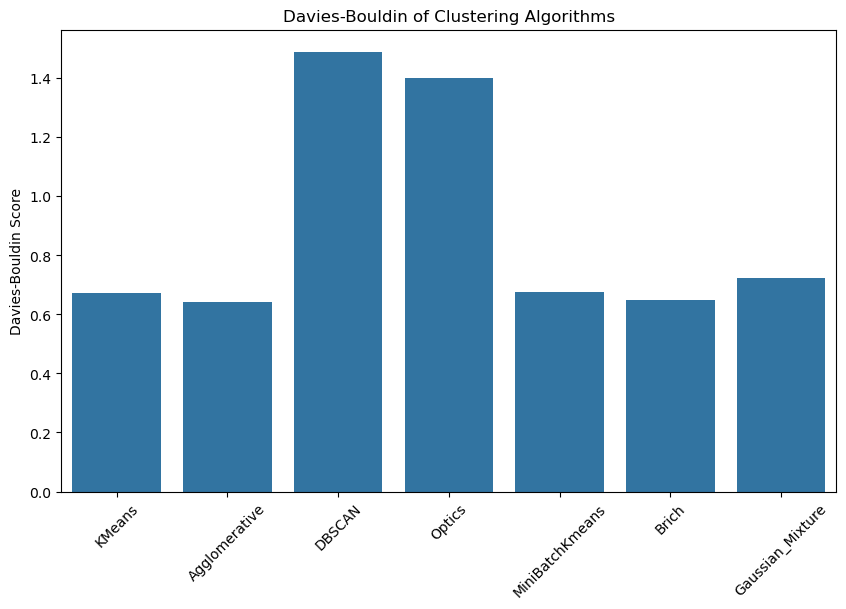

In [20]:
plt.figure(figsize=(10, 6))
scores = [results[name]['Davies-Bouldin Index'] for name in results]
sns.barplot(x=list(results.keys()),y= scores)
plt.title('Davies-Bouldin of Clustering Algorithms')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(rotation=45)
plt.show()

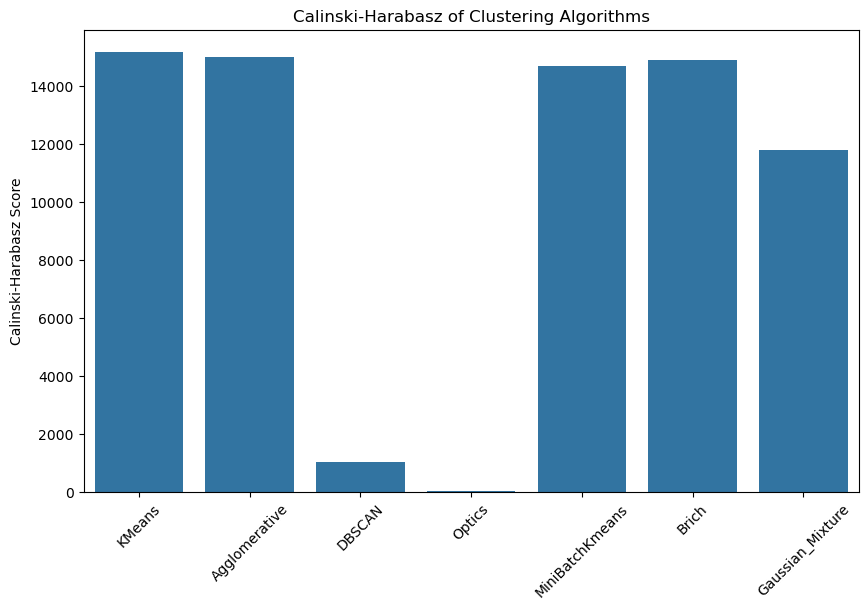

In [22]:
plt.figure(figsize=(10, 6))
scores = [results[name]['Calinski-Harabasz Score'] for name in results]
sns.barplot(x=list(results.keys()),y= scores)
plt.title('Calinski-Harabasz of Clustering Algorithms')
plt.ylabel('Calinski-Harabasz Score')
plt.xticks(rotation=45)
plt.show()

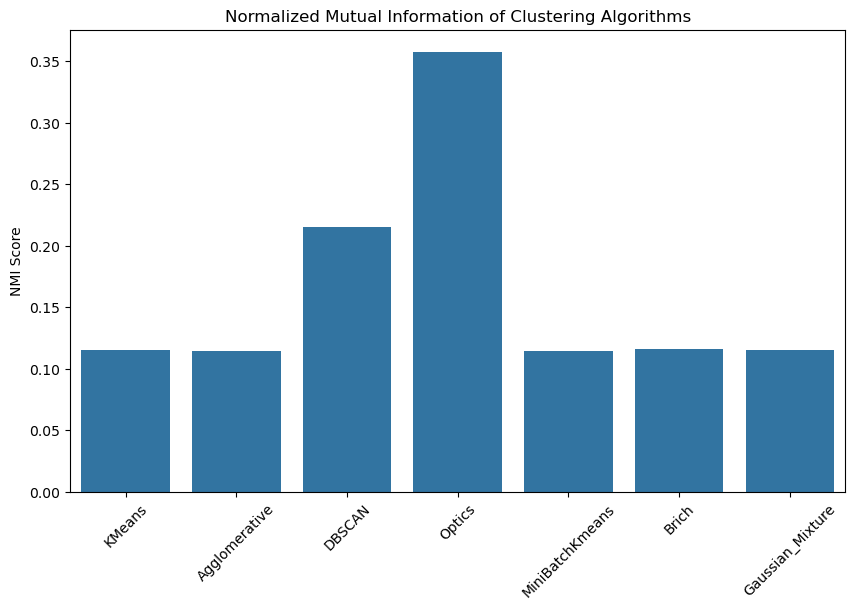

In [23]:
plt.figure(figsize=(10, 6))
scores = [results[name]['Normalized Mutual Information (NMI)'] for name in results]
sns.barplot(x=list(results.keys()),y= scores)
plt.title('Normalized Mutual Information of Clustering Algorithms')
plt.ylabel('NMI Score')
plt.xticks(rotation=45)
plt.show()

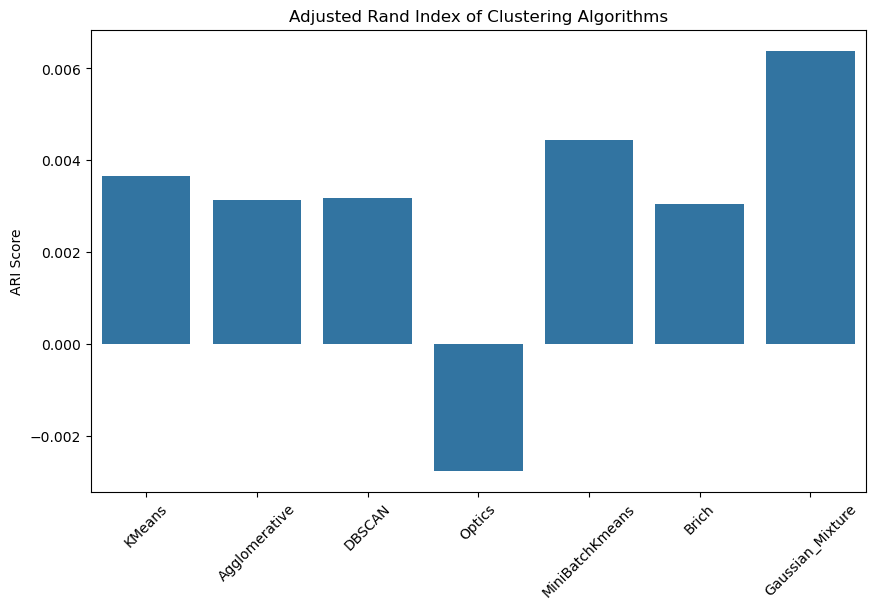

In [24]:
plt.figure(figsize=(10, 6))
scores = [results[name]['Adjusted Rand Index (ARI)'] for name in results]
sns.barplot(x=list(results.keys()),y= scores)
plt.title('Adjusted Rand Index of Clustering Algorithms')
plt.ylabel('ARI Score')
plt.xticks(rotation=45)
plt.show()